In [1]:
from utils_ray import get_info_state, activate_memory_growth; activate_memory_growth(cpu=False)
import tensorflow as tf
from copy import deepcopy, copy
import clubs
import clubs_gym
import gym
from PokerAgent import TensorflowAgent
import time
from random import shuffle
import time
import numpy as np
from utils_ray import print_obs

[INFO] - Models trained on GPU, with memory growth activated.


In [2]:
render_mode = False
env_str = 'LDRL-Poker-v0'
random_model_path = 'memories/trained_advantage-network_player-1_CRF-iteration-4'
trained_model_path = 'value_model_p_0'
agent_fct = TensorflowAgent

# Set game parameters
env_str = 'LDRL-Poker-v0'
num_players = 2
num_streets = 2
num_raises = 3
num_actions = 6
num_cards = [2, 3]
num_suits = 4
num_ranks = 7

n_community_cards = [0] + num_cards[1:]
n_cards_for_hand = min(5, sum(num_cards))
max_bet_number = num_players * num_streets * num_raises

# environment params dict
config_dict = {'num_players': num_players,
                'num_streets': num_streets,
                'blinds': [1, 2],
                'antes': 0,
                'raise_sizes': [2, 4],
                'num_raises': num_raises,
                'num_suits': num_suits,
                'num_ranks': num_ranks,
                'num_hole_cards': num_cards[0],
                'mandatory_num_hole_cards': 0,
                'num_community_cards': n_community_cards,
                'start_stack': 1_000_000,
                'num_cards_for_hand': n_cards_for_hand}

In [3]:
clubs_gym.envs.register({env_str: config_dict})
env = gym.make(env_str)

# create new agents
env.register_agents([agent_fct(model_save_path) for model_save_path in [random_model_path, trained_model_path]])

In [4]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot():
    clear_output(wait=True)
    fig, axs = plt.subplots(2,1, figsize=(8, 8))

    axs[0].plot(range(0, reward_history.shape[0]), reward_history[:,0])
    axs[0].set_title("Player 0's payoff for each game", fontsize=16)
    axs[0].set_xlabel('Game')
    axs[0].set_ylabel('Payoff')

    cum_rew_p_0 = cumulative_reward(reward_history[:,0])
    axs[1].plot(range(0, len(cum_rew_p_0)), cum_rew_p_0)
    axs[1].set_title("Player 0's cumulative payoff", fontsize=16)
    axs[1].set_xlabel('Game')
    axs[1].set_ylabel('cumulative Payoff')

    plt.tight_layout()
    plt.show()

    plt.show()
    
def cumulative_reward(data):
    average = [0]
    
    for value in data:
        average.append(average[-1]+value)
        
    return average

In [5]:
reward_history = None
action_history_p0 = []
action_history_p1 = []
preflop_history_p0 = []
preflop_history_p1 = []

In [6]:
sleep_time = 0.5
max_action = num_actions

env.reset()
env.render()

if render_mode:
    how_many_games = input('Open the rendered Game, input how many games you wanna see and hit Enter to start.')
else:
    how_many_games = input('How many games do you wanna see? Hit enter to start.')
    
for i in range(int(how_many_games)):
    print(f'\n====================== Game {i} ======================\n')
    
    obs = env.reset()
    
    if render_mode:
        env.render()
        time.sleep(sleep_time)
    else:
        print_obs(obs, num_suits)
    
    history = []
    while True:
        if render_mode:
            time.sleep(sleep_time)
            
        # non terminal-state       
        if all(obs['active']) and not obs['action'] == -1:
            # agent chooses bet/action based on info_state
            info_state = get_info_state(obs, history, max_bet_number, env.dealer.num_streets, config_dict)
            bet = env.act(info_state)
            
            # env behaviour changes
            # change action to call amount of chips, when bet != 0 was placed by the agent, but wasn't enough to reach call
            if bet > 0 and bet < obs['call']:
                action = min(int(obs['call']), max_action)
            # change action to min_raise if bet placed, check would have been possible, and min_raise wasn't reached
            elif obs['call'] == 0 and obs['call'] < bet and obs['min_raise'] > 0:
                bet = min(int(obs['min_raise']), max_action)
            
            # take action within environment
            obs, rewards, done, _ = env.step(bet)

            if render_mode:
                env.render()
            else:
                print(f'Action: {bet}', end='\n\n')
                print('------------------------------------------------\n')
                print_obs(obs, num_suits)
        
            # save actions for plots
            if obs['action'] == 0:
                action_history_p0.append(bet)
                if not obs['community_cards']:
                    preflop_history_p0.append(bet)
            else:
                action_history_p1.append(bet)
                if not obs['community_cards']:
                    preflop_history_p1.append(bet)
            history.append(bet)        
        
        # terminal state
        else:               
            # save results      
            if reward_history is None:
                reward_history = np.array([rewards])
            else:
                reward_history = np.append(reward_history, [rewards], axis=0)
            
            # fancy print stuff only without rendering
            if render_mode:
                live_plot()
            else:
                print(f'Payoffs: Player_0 {rewards[0]}, Player_1 {rewards[1]}')
                
            break


/home/janosch/.miniconda3/envs/poker/lib/python3.8/site-packages/clubs/render/graphic.py:107: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.contrib.pyopenssl (/home/janosch/.miniconda3/envs/poker/lib/python3.8/site-packages/urllib3/contrib/pyopenssl.py)']. 
  monkey.patch_all()


clubs table openend at http://127.0.0.1:42187
How many games do you wanna see? Hit enter to start.1000

====================== Game 0 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342146592): 8♦, Card (140693734645824): Q♠]
min_raise: 3, max_raise: 3
call: 1

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 0
Commit: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 1 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140693734645824): Q♠]
min_raise: 3, max_raise: 3
call: 1

Action: 5

------------------------------------------------

---

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146592): 8♦, Card (140689342146832): 9♥, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 9 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147312): 9♣, Card (140689342148416): T♣]
min_raise: 3, max_raise: 3
call: 1

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4
call: 2

Action: 0

------------------------------------------------

--------- game Sta

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147072): 8♣, Card (140693734646256): J♦, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140693734648800): Q♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147072): 8♣, Card (140693734646256): J♦, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140689342148416): T♣]
min_raise: 8, max_raise: 8
call: 4

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147072): 8♣, Card (140693734646256): J♦, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 10
Commit: player_0 6, player_1 4

--------- player 1's turn ---------
hole_cards: [Card (140693734646208): J♠, Card (140689342148416): T♣]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140693734648848): Q♦, Card (140693734631600): A♣]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 25 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140693734645824): Q♠]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game S

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140689342147984): T♥, Card (140689342146736): 9♦]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 0, Player_1 0

====================== Game 32 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140693734630016): A♦]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646208): J♠, Card (140693734646400): Q♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Sta

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140693734631600): A♣, Card (140689342147984): T♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 41 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147312): 9♣, Card (140693734631600): A♣]
min_raise: 3, max_raise: 3
call: 1

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734629488): A♥, Card (140693734646160): J♥]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game St

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140693734646928): K♠]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147648): 8♥, Card (140689342148416): T♣, Card (140693734629488): A♥]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4


Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140689342146592): 8♦, Card (140689342147984): T♥]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140689342146832): 9♥]
min_raise: 4, max_raise: 4
call: 0

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140689342146592): 8♦, Card (140689342147984): T♥]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140693734646160): J♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140689342146592): 8♦, Card (140689342147984): T♥]
Dealer/Button: 0
Pot: 8


Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146832): 9♥, Card (140689342147312): 9♣, Card (140693734632320): K♣]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140689342147264): 9♠]
min_raise: 8, max_raise: 8
call: 4

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146832): 9♥, Card (140689342147312): 9♣, Card (140693734632320): K♣]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 65 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147648): 8♥, Card (140693734646400): Q♣]
min_raise: 3, max_raise: 3
call


--------- game Stats ---------
community_cards: [Card (140693734646400): Q♣, Card (140689342148560): T♠, Card (140693734645968): J♣]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 72 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140693734645968): J♣]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140693734632320): K♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Co

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147984): T♥, Card (140689342147648): 8♥, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 4
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140693734632032): A♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147984): T♥, Card (140689342147648): 8♥, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 8
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140689342147264): 9♠]
min_raise: 8, max_raise: 8
call: 4

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147984): T♥, Card (140689342147648): 8♥, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 0


Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734632032): A♠]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140693734646160): J♥, Card (140693734646256): J♦]
Dealer/Button: 1
Pot: 4
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734632032): A♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140693734646160): J♥, Card (140693734646256): J♦]
Dealer/Button: 1
Pot: 8
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [C

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734646160): J♥, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734646160): J♥, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646208): J♠, Card (140689342147984): T♥]
min_raise: 8, max_raise: 8
call: 4

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734646160): J♥, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 0


Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646928): K♠, Card (140689342147648): 8♥, Card (140693734632320): K♣]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646160): J♥, Card (140689342147072): 8♣]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646928): K♠, Card (140689342147648): 8♥, Card (140693734632320): K♣]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 103 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734630016): A♦, Card (140693734646160): J♥]
min_raise: 3, max_raise: 3
cal

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140693734646928): K♠, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 8
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140689342146832): 9♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140693734646928): K♠, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 12
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140693734630016): A♦]
min_raise: 8, max_raise: 8
call: 4

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140693734646928): K♠, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 0

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734632320): K♣, Card (140693734648752): K♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 119 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140689342147312): 9♣]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734648800): Q♥]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game S

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342146736): 9♦]
min_raise: 4, max_raise: 4
call: 2

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140689342147312): 9♣, Card (140693734645824): Q♠]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342146736): 9♦]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140689342147312): 9♣, Card (140693734645824): Q♠]
Dealer/Button: 1
Pot: 16
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards:

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146832): 9♥, Card (140689342147264): 9♠, Card (140693734648848): Q♦]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 135 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147312): 9♣, Card (140693734631600): A♣]
min_raise: 3, max_raise: 3
call: 1

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 0
Commit: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 136 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140693734645968): J♣]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632032): A♠, Card (140689342148512): T♦, Card (140693734632320): K♣]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140689342147984): T♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632032): A♠, Card (140689342148512): T♦, Card (140693734632320): K♣]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140693734648800): Q♥, Card (140689342147648): 8♥]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140693734646256): J♦]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140693734648800): Q♥, Card (140689342147648): 8♥]
Dealer/Button: 1
Pot: 16
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734629488): A♥, Card (140693734631408): K♦]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140693734648800): Q♥, Card (140689342147648): 8♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
P

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147264): 9♠, Card (140693734645824): Q♠, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734646256): J♦]
min_raise: 8, max_raise: 8
call: 4

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147264): 9♠, Card (140693734645824): Q♠, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 157 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140689342148416): T♣]
min_raise: 3, max_raise: 3
cal

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342146592): 8♦, Card (140689342147648): 8♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140693734631408): K♦]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632032): A♠, Card (140693734646928): K♠, Card (140693734645824): Q♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342146592): 8♦, Card (140689342147648): 8♥]
min_raise: 4, max_raise: 4


Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734629488): A♥, Card (140693734646400): Q♣]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140689342148512): T♦, Card (140693734648848): Q♦]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 172 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140689342147312): 9♣]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648800): Q♥, Card (140693734646256): J♦, Card (140689342147312): 9♣]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 179 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734645968): J♣]
min_raise: 3, max_raise: 3
call: 1

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140689342146448): 8♠]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734648800): Q♥]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646160): J♥, Card (140689342147648): 8♥, Card (140693734645968): J♣]
Dealer/Button: 1
Pot: 4
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734648800): Q♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646160): J♥, Card (140689342147648): 8♥, Card (140693734645968): J♣]
Dealer/Button: 1
Pot: 8
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [C

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140689342146448): 8♠, Card (140693734646208): J♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 193 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140693734648848): Q♦]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140689342147264): 9♠]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game S

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140693734631600): A♣, Card (140689342147264): 9♠]
Dealer/Button: 1
Pot: 16
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734630016): A♦, Card (140693734629488): A♥]
min_raise: 8, max_raise: 8
call: 4

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140693734631600): A♣, Card (140689342147264): 9♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 6, Player_1 -6

====================== Game 200 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342146448): 8♠, Card (140689342146592): 8♦]
min_raise: 3, max_raise: 3
cal

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146736): 9♦, Card (140693734646160): J♥, Card (140693734646208): J♠]
Dealer/Button: 1
Pot: 4
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734632320): K♣]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146736): 9♦, Card (140693734646160): J♥, Card (140693734646208): J♠]
Dealer/Button: 1
Pot: 8
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140693734631408): K♦]
min_raise: 8, max_raise: 8
call: 4

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146736): 9♦, Card (140693734646160): J♥, Card (140693734646208): J♠]
Dealer/Button: 1
Pot: 0


Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140689342148416): T♣]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 10
Commit: player_0 6, player_1 4

--------- player 1's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140689342147984): T♥]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146448): 8♠, Card (140693734646256): J♦, Card (140693734629488): A♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 215 ======================

--------- game 

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734646928): K♠, Card (140693734629488): A♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 221 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734648800): Q♥, Card (140689342146832): 9♥]
min_raise: 3, max_raise: 3
call: 1

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140693734630016): A♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646928): K♠, Card (140693734646400): Q♣, Card (140689342147264): 9♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 228 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734630016): A♦]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147648): 8♥, Card (140689342146736): 9♦]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 0
Commit: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 236 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140693734631600): A♣]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734648752): K♥, Card (140693734645968): J♣]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146736): 9♦, Card (140693734648800

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140689342147648): 8♥, Card (140693734631600): A♣]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 243 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734630016): A♦, Card (140693734646928): K♠]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342146448): 8♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140693734648848): Q♦, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140693734631408): K♦]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140693734648848): Q♦, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342147312): 9♣]
min_raise: 8, max_raise: 8
call: 4

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140693734648848): Q♦, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 0


Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342147312): 9♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734646160): J♥]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342147312): 9♣]
min_raise: 4, max_raise: 4
call: 2

Action: 3

------------------------------------------------

--------- g

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146592): 8♦, Card (140689342147648): 8♥, Card (140693734630016): A♦]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 264 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140689342147264): 9♠]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140693734646400): Q♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147984): T♥, Card (140693734632320): K♣, Card (140693734646208): J♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -10, Player_1 10

====================== Game 269 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734632320): K♣]
min_raise: 3, max_raise: 3
call: 1

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 10
Commit: player_0 6, player_1 4

--------- player 1's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140693734646256): J♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631600): A♣, Card (140693734648800): Q♥, Card (140693734645968): J♣]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 277 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140693734648848): Q♦]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game 

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 0
Commit: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 283 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140689342148416): T♣]
min_raise: 3, max_raise: 3
call: 1

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140693734646256): J♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140693734630016

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734648752): K♥, Card (140689342146448): 8♠]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140689342147072): 8♣, Card (140689342146736): 9♦]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140693734646208): J♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140689342147072): 8♣, Card (140689342146736): 9♦]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140689342148560): T♠]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140693734629488): A♥, Card (140693734632032): A♠]
min_raise: 4, max_raise: 4
call: 2

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147072): 8♣, Card (140689342146448): 8♠, Card (140693734646208): J♠]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734629488): A♥, Card (140693734632032): A♠]
min_raise: 4, max_raise: 

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734632320): K♣]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146736): 9♦, Card (140689342147648): 8♥, Card (140689342146832): 9♥]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646208): J♠, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140693734645824): Q♠]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646400): Q♣, Card (140693734646256): J♦, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734646208): J♠, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4


Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147264): 9♠, Card (140693734646400): Q♣, Card (140693734646928): K♠]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734646160): J♥, Card (140693734632032): A♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147264): 9♠, Card (140693734646400): Q♣, Card (140693734646928): K♠]
Dealer/Button: 1
Pot: 16
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140689342146448): 8♠]
min_raise: 8, max_raise: 8
call: 4

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147264): 9♠, Card (140693734646400): Q♣, Card (140693734646928): K♠]
Dealer/Button: 1
Pot: 

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147984): T♥, Card (140693734646928): K♠, Card (140693734645824): Q♠]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140689342147264): 9♠]
min_raise: 8, max_raise: 8
call: 4

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147984): T♥, Card (140693734646928): K♠, Card (140693734645824): Q♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 325 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342148416): T♣]
min_raise: 3, max_raise: 3
cal

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734645824): Q♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140693734646256): J♦]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147648): 8♥, Card (140689342147984): T♥, Card (140693734646400): Q♣]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734645824): Q♠]
min_raise: 4, max_raise: 4


Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646160): J♥, Card (140693734646256): J♦]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648800): Q♥, Card (140693734630016): A♦, Card (140693734632320): K♣]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4


Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148416): T♣, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147984): T♥, Card (140693734646160): J♥, Card (140689342148512): T♦]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 348 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140689342146736): 9♦]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game S

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148512): T♦, Card (140693734629488): A♥, Card (140693734632032): A♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -8, Player_1 8

====================== Game 355 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140689342147264): 9♠]
min_raise: 3, max_raise: 3
call: 1

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140689342147648): 8♥]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game S

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140689342147312): 9♣, Card (140689342148512): T♦]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342146448): 8♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140689342147312): 9♣, Card (140689342148512): T♦]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646160): J♥, Card (140693734645824): Q♠]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140689342147312): 9♣, Card (140689342148512): T♦]
Dealer/Button: 0
Pot: 0

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140689342146448): 8♠]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734629488): A♥, Card (140689342147984): T♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 370 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342146832): 9♥]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game S

community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140689342146592): 8♦]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734630016): A♦, Card (140689342147312): 9♣]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734646256): J♦, Card (140693734632320): K♣]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats -


--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646400): Q♣, Card (140689342148560): T♠, Card (140689342148512): T♦]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646400): Q♣, Card (140689342148560): T♠, Card (140689342148512): T♦]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140693734629488): A♥]
min_r

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734646256): J♦, Card (140689342146448): 8♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 390 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734629488): A♥, Card (140693734646928): K♠]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140693734646160): J♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632032): A♠, Card (140689342148416): T♣, Card (140693734646928): K♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -6, Player_1 6

====================== Game 399 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140689342146592): 8♦]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140689342147264): 9♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140693734632320): K♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140693734631408): K♦, Card (140693734646160): J♥]
Dealer/Button: 1
Pot: 8
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140693734632320): K♣]
min_raise: 4, max_raise: 4


Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 2

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734645824): Q♠, Card (140693734645968): J♣, Card (140693734646928): K♠]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734645824): Q♠, Card (140693734645968): J♣, Card (140693734646928): K♠]
Dealer/Button: 1
Pot: 16
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards:

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4
call: 2

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140693734646928): K♠, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 420 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734646400): Q♣]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game S

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342146592): 8♦, Card (140693734646400): Q♣]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646928): K♠, Card (140693734631408): K♦, Card (140693734645824): Q♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 428 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140693734646160): J♥]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game S

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148512): T♦, Card (140689342147072): 8♣, Card (140693734645824): Q♠]
Dealer/Button: 1
Pot: 16
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734646160): J♥, Card (140689342147648): 8♥]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148512): T♦, Card (140689342147072): 8♣, Card (140693734645824): Q♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 10, Player_1 -10

====================== Game 434 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342146448): 8♠, Card (140693734631408): K♦]
min_raise: 3, max_raise: 3
c

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140693734629488): A♥]
min_raise: 4, max_raise: 4
call: 2

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147648): 8♥, Card (140693734645824): Q♠, Card (140693734631600): A♣]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140693734629488): A♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147648): 8♥, Card (140693734645824): Q♠, Card (140693734631600): A♣]
Dealer/Button: 1
Pot: 16
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards:

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147648): 8♥, Card (140693734632032): A♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140689342148416): T♣]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140693734630016): A♦, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342147648): 8♥, Card (140693734632032): A♠]
min_raise: 4, max_raise: 4



--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146736): 9♦, Card (140693734632320): K♣, Card (140689342146448): 8♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 452 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342148416): T♣, Card (140693734646400): Q♣]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
C

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140689342146736): 9♦]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140693734648848): Q♦]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140689342146736): 9♦]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): 

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147648): 8♥, Card (140693734645968): J♣]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146832): 9♥, Card (140693734645824): Q♠, Card (140693734646208): J♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4


Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734631408): K♦, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 8
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342146448): 8♠, Card (140693734646400): Q♣]
min_raise: 8, max_raise: 8
call: 4

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734631408): K♦, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 478 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140689342148416): T♣]
min_raise: 3, max_raise: 3
call

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632032): A♠, Card (140693734632320): K♣, Card (140689342147984): T♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140693734648848): Q♦]
min_raise: 8, max_raise: 8
call: 4

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632032): A♠, Card (140693734632320): K♣, Card (140689342147984): T♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 487 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140689342146736): 9♦]
min_raise: 3, max_raise: 3
cal

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734646928): K♠, Card (140689342146832): 9♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734632032): A♠]
min_raise: 8, max_raise: 8
call: 4

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734646928): K♠, Card (140689342146832): 9♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -8, Player_1 8

====================== Game 495 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140689342146592): 8♦]
min_raise: 3, max_raise: 3
cal

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140689342147984): T♥]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734645968): J♣, Card (140693734631408): K♦, Card (140693734629488): A♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 504 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734631408): K♦]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game S

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140689342148512): T♦, Card (140689342146832): 9♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 510 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140693734629488): A♥]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734645824): Q♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140693734631600): A♣, Card (140693734648800): Q♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 6, Player_1 -6

====================== Game 519 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140693734646928): K♠]
min_raise: 3, max_raise: 3
call: 1

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140693734630016): A♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146592): 8♦, Card (140693734646928): K♠, Card (140689342147264): 9♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 528 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140693734646928): K♠]
min_raise: 3, max_raise: 3
call: 1

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 0
Commit: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 529 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140693734632032): A♠, Card (140689342147072): 8♣]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734632320): K♣]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140693734632032): A♠, Card (140689342147072): 8♣]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646160): J♥, Card (140689342148512): T♦]
min_raise: 8, max_raise: 8
call: 4

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140693734632032): A♠, Card (140689342147072): 8♣]
Dealer/Button: 0
Pot: 0


Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146736): 9♦, Card (140693734646400): Q♣, Card (140689342147072): 8♣]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140689342146832): 9♥]
min_raise: 8, max_raise: 8
call: 4

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146736): 9♦, Card (140693734646400): Q♣, Card (140689342147072): 8♣]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 547 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734646928): K♠]
min_raise: 3, max_raise: 3
cal

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140689342147312): 9♣]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734645968): J♣, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4


Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140693734648800): Q♥]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140693734648752): K♥, Card (140693734645824): Q♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 562 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734648752): K♥, Card (140693734646208): J♠]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game S

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146448): 8♠, Card (140693734645968): J♣, Card (140689342147264): 9♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 569 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734648800): Q♥, Card (140689342147264): 9♠]
min_raise: 3, max_raise: 3
call: 1

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342147312): 9♣]
min_raise: 4, max_raise: 4
call: 2

Action: 0

------------------------------------------------

--------- game S

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342146592): 8♦, Card (140693734648800): Q♥]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140689342148512): T♦, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140689342146832): 9♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140689342148512): T♦, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146592): 8♦, Card (140689342147312): 9♣, Card (140689342147984): T♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 585 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342146448): 8♠, Card (140689342147648): 8♥]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 10
Commit: player_0 6, player_1 4

--------- player 1's turn ---------
hole_cards: [Card (140693734630016): A♦, Card (140689342148416): T♣]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140689342146832): 9♥, Card (140689342148512): T♦]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 593 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342147648): 8♥]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game 

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734648800): Q♥, Card (140693734632032): A♠]
Dealer/Button: 1
Pot: 4
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734630016): A♦, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 0

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734648800): Q♥, Card (140693734632032): A♠]
Dealer/Button: 1
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140693734645824): Q♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734648800): Q♥, Card (140693734632032): A♠]
Dealer/Button: 1
Pot: 8


Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342148560): T♠]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140689342146736): 9♦, Card (140693734631600): A♣]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342148560): T♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140689342146736): 9♦, Card (140693734631600): A♣]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [C

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147072): 8♣, Card (140689342146592): 8♦, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 16
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140693734646256): J♦]
min_raise: 8, max_raise: 8
call: 4

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147072): 8♣, Card (140689342146592): 8♦, Card (140689342147312): 9♣]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -6, Player_1 6

====================== Game 612 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140689342147072): 8♣]
min_raise: 3, max_raise: 3
cal

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648800): Q♥, Card (140689342148416): T♣, Card (140689342147648): 8♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140693734632320): K♣]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648800): Q♥, Card (140689342148416): T♣, Card (140689342147648): 8♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -8, Player_1 8

====================== Game 621 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140693734629488): A♥]
min_raise: 3, max_raise: 3
cal

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734645968): J♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140693734646160): J♥]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734645968): J♣]
min_raise: 4, max_raise: 4
call: 2

Action: 3

------------------------------------------------

--------- g

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140693734632320): K♣, Card (140693734629488): A♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 638 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140689342146736): 9♦]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147648): 8♥, Card (140693734646400): Q♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140693734630016): A♦, Card (140689342147648): 8♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 645 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140693734646256): J♦]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140689342148416): T♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140693734632320): K♣]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 10
Commit: player_0 6, player_1 4

--------- player 1's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140689342147072): 8♣]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648848): Q♦, Card (140693734648800): Q♥, Card (140689342147648): 8♥]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 655 ======================

--------- game 

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140693734646256): J♦]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734648848): Q♦]
min_raise: 4, max_raise: 4
call: 2

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140689342147312): 9♣, Card (140693734648752): K♥]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140693734646256): J♦]
min_raise: 4, max_raise: 4


Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140693734632320): K♣]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140693734645968): J♣, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734648752): K♥]
min_raise: 4, max_raise: 4


Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146448): 8♠, Card (140693734632320): K♣, Card (140689342147264): 9♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 680 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140693734648800): Q♥]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147312): 9♣, Card (140689342146832): 9♥]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646928): K♠, Card (140693734632320): K♣, Card (140689342146832): 9♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 688 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734648800): Q♥, Card (140693734632320): K♣]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147648): 8♥, Card (140689342146448): 8♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140689342147072): 8♣]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147312): 9♣, Card (140689342147648): 8♥, Card (140693734646208): J♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 696 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734646208): J♠, Card (140689342148416): T♣]
min_raise: 3, max_raise: 3
call: 1

Action: 0

------------------------------------------------

--------- game S

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140689342146736): 9♦, Card (140693734645824): Q♠]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140689342146448): 8♠]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140689342146736): 9♦, Card (140693734645824): Q♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -8, Player_1 8

====================== Game 707 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342146832): 9♥, Card (140693734646208): J♠]
min_raise: 3, max_raise: 3
cal

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646928): K♠, Card (140689342146592): 8♦, Card (140693734629488): A♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 716 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140693734646160): J♥]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140689342147072): 8♣]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game S

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140693734648800): Q♥]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734629488): A♥, Card (140693734648848): Q♦, Card (140689342146832): 9♥]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342147312): 9♣]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734629488): A♥, Card (140693734648848): Q♦, Card (140689342146832): 9♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140693734646400): Q♣]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140693734645968): J♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140693734646400): Q♣]
min_raise: 4, max_raise: 4
call: 2

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147984): 

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646928): K♠, Card (140689342148560): T♠]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734632032): A♠, Card (140693734648800): Q♥]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140693734646160): J♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148416): T♣, Card (140693734632032): A♠, Card (140693734648800): Q♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734646208): J♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140693734645968): J♣]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734646208): J♠]
min_raise: 4, max_raise: 4
call: 2

Action: 3

------------------------------------------------

--------- g

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648800): Q♥, Card (140689342146592): 8♦, Card (140693734646160): J♥]
Dealer/Button: 1
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140693734646208): J♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648800): Q♥, Card (140689342146592): 8♦, Card (140693734646160): J♥]
Dealer/Button: 1
Pot: 8
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734629488): A♥, Card (140693734645824): Q♠]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648800): Q♥, Card (140689342146592): 8♦, Card (140693734646160): J♥]
Dealer/Button: 1
Pot: 0


Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140689342147264): 9♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646160): J♥, Card (140693734632320): K♣]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 10
Commit: player_0 6, player_1 4

--------- player 1's turn ---------
hole_cards: [Card (140693734646256): J♦, Card (140689342147264): 9♠]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- g

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140693734631600): A♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140693734646256): J♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140693734645968): J♣, Card (140689342146736): 9♦]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 774 ======================

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140689342147312): 9♣, Card (140689342147984): T♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 782 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140693734630016): A♦]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140689342146832): 9♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140693734648752): K♥, Card (140689342146592): 8♦]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140693734645824): Q♠]
min_raise: 4, max_raise: 4
call: 0

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140693734648752): K♥, Card (140689342146592): 8♦]
Dealer/Button: 0
Pot: 4
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734646160): J♥, Card (140693734629488): A♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140693734648752): K♥, Card (140689342146592): 8♦]
Dealer/Button: 0
Pot: 8


Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147264): 9♠, Card (140693734632032): A♠, Card (140693734630016): A♦]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140693734632320): K♣]
min_raise: 8, max_raise: 8
call: 4

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147264): 9♠, Card (140693734632032): A♠, Card (140693734630016): A♦]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -8, Player_1 8

====================== Game 799 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140693734646160): J♥]
min_raise: 3, max_raise: 3
cal

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140693734646208): J♠, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734631408): K♦, Card (140693734648800): Q♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140693734646208): J♠, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140689342147984): T♥]
min_raise: 8, max_raise: 8
call: 4

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734632320): K♣, Card (140693734646208): J♠, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734645968): J♣, Card (140689342147648): 8♥]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140689342146448): 8♠, Card (140693734646928): K♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140689342147264): 9♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140689342146448): 8♠, Card (140693734646928): K♠]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140689342146736): 9♦, Card (140693734648800): Q♥]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140693734646928): K♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140689342146736): 9♦, Card (140693734648800): Q♥]
Dealer/Button: 1
Pot: 16
Commit: player_0 4, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140689342147264): 9♠]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140689342146736): 9♦, Card (140693734648800): Q♥]
Dealer/Button: 1
Pot: 

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140693734632320): K♣, Card (140693734648848): Q♦]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 828 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734646208): J♠, Card (140689342148512): T♦]
min_raise: 3, max_raise: 3
call: 1

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 0
Commit: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 829 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140693734645824): Q♠]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146592): 8♦, Card (140689342147312): 9♣, Card (140689342147648): 8♥]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140693734629488): A♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146592): 8♦, Card (140689342147312): 9♣, Card (140689342147648): 8♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148416): T♣, Card (140693734629488): A♥]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734645968): J♣, Card (140693734645824): Q♠, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342147312): 9♣, Card (140693734648800): Q♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734645968): J♣, Card (140693734645824): Q♠, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140693734632320): K♣, Card (140689342146448): 8♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 853 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140689342146448): 8♠]
min_raise: 3, max_raise: 3
call: 1

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140689342147312): 9♣]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646208): J♠, Card (140693734632320): K♣, Card (140693734632032): A♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 862 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734629488): A♥, Card (140693734646928): K♠]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342148560): T♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147984): T♥, Card (140693734645968): J♣]
min_raise: 4, max_raise: 4
call: 2

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631600): A♣, Card (140693734631408): K♦, Card (140689342147072): 8♣]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 872 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342147648): 8♥, Card (140693734648800): Q♥]
min_raise: 3, max_raise: 3
call: 1

Action: 0

------------------------------------------------

--------- game S

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140693734646928): K♠, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140693734631600): A♣]
min_raise: 8, max_raise: 8
call: 4

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140693734646928): K♠, Card (140689342148560): T♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 879 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734648800): Q♥, Card (140693734646928): K♠]
min_raise: 3, max_raise: 3
cal

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146448): 8♠, Card (140689342147984): T♥, Card (140689342146736): 9♦]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 888 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140693734631600): A♣]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734648752): K♥, Card (140693734645824): Q♠]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 0
Commit: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 897 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140693734632320): K♣]
min_raise: 3, max_raise: 3
call: 1

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 0
Commit: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 898 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342146448): 8♠, 

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 10
Commit: player_0 6, player_1 4

--------- player 1's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140693734629488): A♥]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140689342147984): T♥, Card (140693734646928): K♠]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 907 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734630016): A♦, Card (140693734645824): Q♠]
min_raise: 3, max_raise: 3
call: 1

Action: 5

------------------------------------------------

--------- game 

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140689342146736): 9♦]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342146448): 8♠, Card (140693734645968): J♣]
min_raise: 4, max_raise: 4
call: 2

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734630016): A♦, Card (140689342146832): 9♥, Card (140693734646928): K♠]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 916 ======================

--------- game S

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140689342147264): 9♠, Card (140689342147648): 8♥]
min_raise: 3, max_raise: 3
call: 1

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140693734648848): Q♦]
min_raise: 4, max_raise: 4
call: 2

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342147312): 9♣, Card (140689342146736): 9♦, Card (140693734630016): A♦]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 924 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Co

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 4
Commit: player_0 2, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734631600): A♣, Card (140689342146592): 8♦]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734648800): Q♥, Card (140693734645968): J♣]
min_raise: 4, max_raise: 4
call: 2

Action: 0

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148560): T♠, Card (140689342146448): 8♠, Card (140689342147984): T♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 932 ======================

--------- game S

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140689342147264): 9♠, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140693734645824): Q♠, Card (140689342147648): 8♥]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140689342147264): 9♠, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140693734631600): A♣]
min_raise: 8, max_raise: 8
call: 4

Action: 3

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734648752): K♥, Card (140689342147264): 9♠, Card (140693734646160): J♥]
Dealer/Button: 0
Pot: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342148416): T♣, Card (140693734646400): Q♣]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140693734646256): J♦, Card (140689342147312): 9♣]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342148560): T♠, Card (140693734645824): Q♠]
min_raise: 4, max_raise: 4
call: 0

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631408): K♦, Card (140693734646256): J♦, Card (140689342147312): 9♣]
Dealer/Button: 0
Pot: 12
Commit: player_0 0, player_1 4

--------- player 0's turn ---------
hole_cards: [

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342148416): T♣, Card (140693734645968): J♣]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140689342146736): 9♦, Card (140689342148512): T♦]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646256): J♦, Card (140689342146832): 9♥, Card (140693734631600): A♣]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342148416): T♣, Card (140693734645968): J♣]
min_raise: 4, max_raise: 4



--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 10
Commit: player_0 6, player_1 4

--------- player 1's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140689342146592): 8♦]
min_raise: 4, max_raise: 4
call: 2

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734631600): A♣, Card (140693734646928): K♠, Card (140689342147072): 8♣]
Dealer/Button: 0
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 965 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 3
Commit: player_0 2, player_1 1

--------- player 1's turn ---------
hole_cards: [Card (140693734648848): Q♦, Card (140693734646400): Q♣]
min_raise: 3, max_raise: 3
call: 1

Action: 5

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6


Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 6
Commit: player_0 4, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734630016): A♦, Card (140693734646256): J♦]
min_raise: 4, max_raise: 4
call: 2

Action: 4

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 1
Pot: 10
Commit: player_0 4, player_1 6

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342148560): T♠]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146448): 8♠, Card (140689342146592): 8♦, Card (140693734648848): Q♦]
Dealer/Button: 1
Pot: 12
Commit: player_0 0, player_1 0

--------- player 0's turn ---------
hole_cards: [Card (140693734632320): K♣, Card (140689342148560): T♠]
min_raise: 4, max_raise: 

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140693734646928): K♠, Card (140689342147072): 8♣, Card (140693734646160): J♥]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 980 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140689342148512): T♦, Card (140693734645824): Q♠]
min_raise: 3, max_raise: 3
call: 1

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140693734648800): Q♥, Card (140693734648752): K♥]
min_raise: 2, max_raise: 2
call: 0

Action: 0

------------------------------------------------

--------- game S

Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147312): 9♣, Card (140693734648800): Q♥]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 6
Commit: player_0 2, player_1 4

--------- player 0's turn ---------
hole_cards: [Card (140693734646400): Q♣, Card (140689342146736): 9♦]
min_raise: 4, max_raise: 4
call: 2

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342146832): 9♥, Card (140689342148560): T♠, Card (140689342147264): 9♠]
Dealer/Button: 0
Pot: 8
Commit: player_0 0, player_1 0

--------- player 1's turn ---------
hole_cards: [Card (140689342147312): 9♣, Card (140693734648800): Q♥]
min_raise: 4, max_raise: 4


Action: 1

------------------------------------------------

--------- game Stats ---------
community_cards: [Card (140689342148512): T♦, Card (140693734645968): J♣, Card (140689342147072): 8♣]
Dealer/Button: 1
Pot: 0
Commit: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 998 ======================

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 3
Commit: player_0 1, player_1 2

--------- player 0's turn ---------
hole_cards: [Card (140693734632032): A♠, Card (140689342146832): 9♥]
min_raise: 3, max_raise: 3
call: 1

Action: 2

------------------------------------------------

--------- game Stats ---------
community_cards: []
Dealer/Button: 0
Pot: 4
Commit: player_0 2, player_1 2

--------- player 1's turn ---------
hole_cards: [Card (140689342147072): 8♣, Card (140689342146592): 8♦]
min_raise: 2, max_raise: 2
call: 0

Action: 2

------------------------------------------------

--------- game S

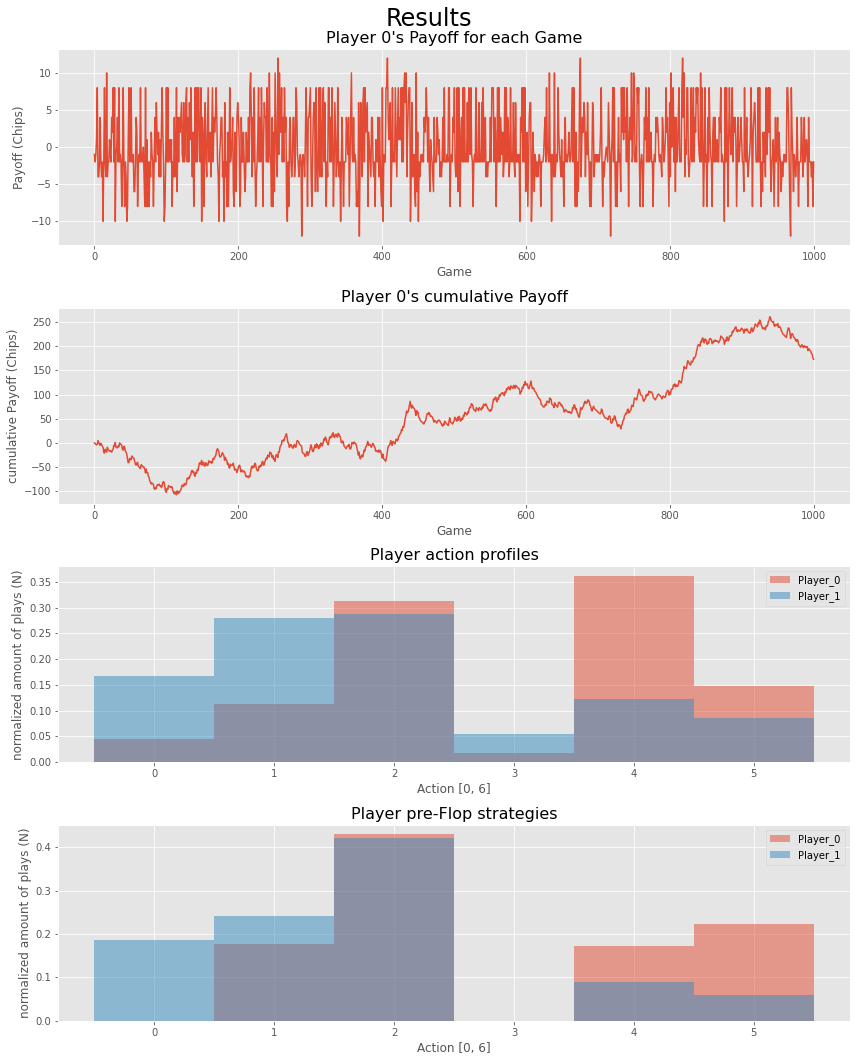

In [11]:
plt.style.use('ggplot')
fig, axs = plt.subplots(4,1, figsize=(12, 15))


# payoff
axs[0].plot(range(0, reward_history.shape[0]), reward_history[:,0])
axs[0].set_title("Player 0's Payoff for each Game", fontsize=16)
axs[0].set_xlabel('Game')
axs[0].set_ylabel('Payoff (Chips)')


# cumulative payoff
cum_rew_p_0 = cumulative_reward(reward_history[:,0])
axs[1].plot(range(0, len(cum_rew_p_0)), cum_rew_p_0)
axs[1].set_title("Player 0's cumulative Payoff", fontsize=16)
axs[1].set_xlabel('Game')
axs[1].set_ylabel('cumulative Payoff (Chips)')


# actions
# 0 indicates a check or a fold, hence difficult to interprete
bins = np.arange(num_actions+1)-0.5

axs[2].hist(action_history_p0, bins=bins, alpha=.5, label='Player_0', density=True)
axs[2].hist(action_history_p1, bins=bins, alpha=.5, label='Player_1', density=True)

axs[2].set_title("Player action profiles", fontsize=16)
axs[2].set_xlabel('Action [0, 6]')
axs[2].set_ylabel('normalized amount of plays (N)')
axs[2].legend(loc='upper right')


# preflop strategies
bins = np.arange(num_actions+1)-0.5

axs[3].hist(preflop_history_p0, bins=bins, alpha=.5, label='Player_0', density=True)
axs[3].hist(preflop_history_p1, bins=bins, alpha=.5, label='Player_1', density=True)

axs[3].set_title("Player pre-Flop strategies", fontsize=16)
axs[3].set_xlabel('Action [0, 6]')
axs[3].set_ylabel('normalized amount of plays (N)')
axs[3].legend(loc='upper right')

# make fancy and show
plt.suptitle('Results', fontsize=24)
plt.tight_layout()
plt.show()